In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb

# load data
data = pd.read_csv('../data/merged_data.csv')

data.shape

(1917, 424)

### The workflow for the data model is as follows:
1. Extract dataframe for each data group
2. Consolidate into 2 dataframes for categorical and numerical data
3. Consolidate into 1 dataframe for all data
4. Create dataframes with target variables for regression and classification
5. Implement lighweight ML pipelines to evaluate how the data fits the model
6. Evaluate model performance and iterate on data model

### Review Numeric Data

In [2]:
# in this cell we will create a number of dataframes that will merge into dataset for ML

# first we will group numeric and cat columns that are numeric

# create rsa df, including cols for baseline assessment plus 4 weeks of treatment
# rsa = data[[col for col in data.columns if 'rsa' in col]].iloc[:, :5]

# create df for meds df, including cols for baseline assessment plus 4 weeks of treatment
# meds = data[[col for col in data.columns if 'med' in col]].iloc[:, :10]

# create df for tests df, including cols for baseline assessment plus 4 weeks of treatment
tests = data[[col for col in data.columns if 'test' in col]].iloc[:, :45]

# create df for survey df, including cols for baseline assessment plus 4 weeks of treatment
# survey = data[[col for col in data.columns if 'survey' in col]].iloc[:, :20]

# extract demographic columns that are in binary format
dem_num  = data[[col for col in data.columns if col.startswith('dem_') and col not in ['dem_gender','dem_ethnicity']]]

# concat num features into num_df
num_df = pd.concat([tests, dem_num], axis=1)

num_df

,test_Propoxyphene_0,test_Amphetamines_0,test_Cannabinoids_0,test_Benzodiazepines_0,test_MMethadone_0,test_Oxycodone_0,test_Cocaine_0,test_Methamphetamine_0,test_Opiate300_0,test_Propoxyphene_1,...,test_Methamphetamine_4,test_Opiate300_4,dem_race_no_answer,dem_race_unknown,dem_race_amer_ind,dem_race_asian,dem_race_black,dem_race_pacific_islander,dem_race_white,dem_race_other
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1913,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1914,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1915,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Review Categorical Data

In [3]:
# next we will group the cat columns with text strings and one hot encode them

# create df for demographics
dem_cat = data[[col for col in data.columns if col.startswith('dem_') 
                and col in 'dem_gender' or 'dem_ethnicity' in col]]

# create df for diagnosis
dsm = data[[col for col in data.columns if col.startswith('dsm_')]]

# create df for medical history
#mdh = data[[col for col in data.columns if col.startswith('mdh_')]]

# create df for physical exam
#pex = data[[col for col in data.columns if col.startswith('pex_')]]

# concat cat features into cat_df
cat_df = pd.concat([dem_cat, dsm], axis=1)

# one hot encode cat_df
cat_df = pd.get_dummies(cat_df, dtype=int)

cat_df



,dem_gender_0,dem_gender_female,dem_gender_male,dem_ethnicity_0,dem_ethnicity_not_spanish_origin,dem_ethnicity_spanish_origin,dsm_cannabis_abuse,dsm_cannabis_dependence,dsm_cannabis_no_diagnosis,dsm_cannabis_not_evaluated,...,dsm_alcohol_abuse,dsm_alcohol_dependence,dsm_alcohol_no_diagnosis,dsm_alcohol_not_evaluated,dsm_alcohol_not_present,dsm_amphetamine_abuse,dsm_amphetamine_dependence,dsm_amphetamine_no_diagnosis,dsm_amphetamine_not_evaluated,dsm_amphetamine_not_present
0,0,0,1,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
1,0,0,1,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
2,0,0,1,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
3,0,1,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,0,1,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
1913,0,0,1,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
1914,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1915,0,0,1,0,1,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0


### Create 2 dataframes for classification and regression models
1. Classification Dataframe - will use the responder column as the target
2. Regression Dataframe - will use the NTR (negative test rate) column as the target

In [4]:
# ceate variable for target, which is the negative test rate
#ntr = data['NTR']
ntr = data['NTR']
responder = data['responder']
 
# merge df num, cat and ntr
classification_df = pd.concat([num_df, cat_df, responder], axis=1)
regression_df = pd.concat([num_df, cat_df, ntr], axis=1)

classification_df.shape, regression_df.shape

((1917, 89), (1917, 89))

### Run a simple regression model


In [5]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

X, y = regression_df.drop('NTR', axis=1), regression_df['NTR']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=10, max_depth=3)

xg_reg.fit(X_train, y_train)

preds = xg_reg.predict(X_test)

from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.158213


### Plot tree to see the structure of the decision tree

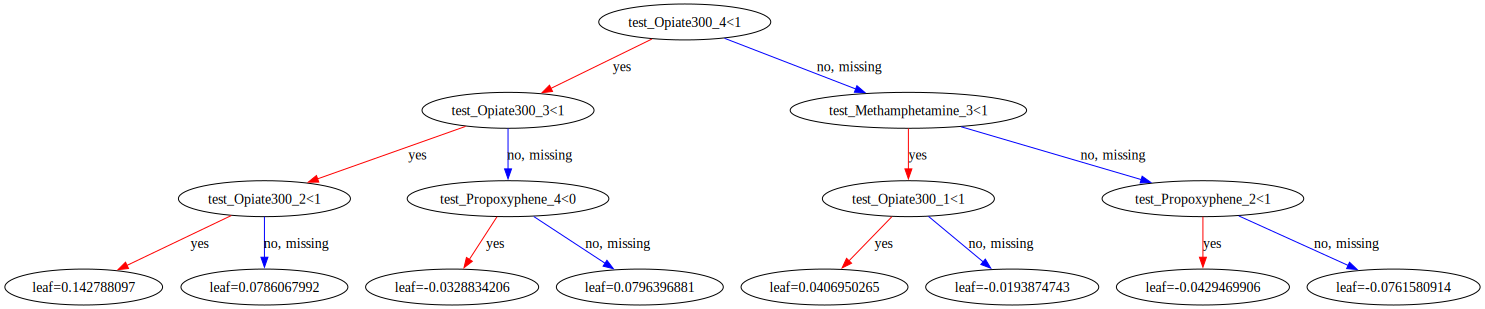

In [6]:
import xgboost as xgb
from graphviz import Source

# Assuming 'xg_reg' is your trained XGBoost model
graph = xgb.to_graphviz(xg_reg, num_trees=0)

# Display the tree plot directly in the notebook
graph

### Hyperparameter tuning
The parameters that can be tuned are significantly different for each base learner<br>
<br>
For the tree based learner -  Most frequently tuned parameters are outlined below.<br>
<br>
<u>learning rate</u> - Effects how quickly the model fits the residual error using additional base learners<br>
<br>
A low learning rate will require more boosting rounds to achieve the same reduction in residual error, compared to a model with a high learning rate<br>
<br>

<u>Regularization</u> - Applies penalty to prediction errors within a certain threshold, to reduce overfitting<br>
<u>gamma</u> - min loss reduction to create new tree split<br>
<u>lambda</u> - L2 regularization on leaf weights<br>
<u>alpha</u> - L1 regularization on leaf weights<br>
<br>To learn more about L1 and L2 regularization, please read the following      [article](https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c)<br>
<br>
<u>max_depth</u> - positive integer value - effects how deeply each tree is allowed to grow during any given boosting round<br>
<br>
<u>subsample</u> - value between 0 - 1, fraction of the training set that can be used for any giving boosting round.  Low and high values can lead to under and overfitting<br>
<br>
<u>colsample_bytree</u> - fraction of features you can select from during any given boosting round and must also be a value between 0 and 1<br><br>
A large value means that almost all features can be used to build a tree, during a given boosting round, where as a small value means that as the fraction  of features  that can be selected from is very small.  In general smaller colsamplebytree values, behaves as additional regularization to the model.  Where using all columns in certain cases can overfit a trained model.<br>
<br>
For the linear based learner the number of tunable parameters is much smaller, L1 and L2 regularization for the weights, model bias<br><br>
Number of estimators is a tunable parameter
The parameters that can be tuned are significantly different for each base learner
<br>

For the linear based learner the number of tunable parameters is much smaller, L1 and L2 regularization for the weights, model bias
Number of estimators is a tunable parameter

### Learning Rate

In [7]:
# hyperparameter tuning - Learning Rate

# define X, y
X, y = regression_df.drop('NTR', axis=1), regression_df['NTR']

# Create dmatrix with oud clinical data
oud_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary for each tree (boosting round)
params = {"objective":"reg:linear", "max_depth":3}

# Create list of eta values and empty list to store final round rmse per xgboost model
eta_vals = [0.001, 0.01, 0.1, 0.2, 0.3]
best_rmse = []

# Systematically vary the eta 
for curr_val in eta_vals:

    params["eta"] = curr_val
    
    # Perform cross-validation: cv_results
    cv_results = xgb.cv(dtrain=oud_dmatrix, params=params, nfold=3,
                    num_boost_round=10, early_stopping_rounds=5,
                    metrics="rmse", as_pandas=True, seed=123)
    
    # Append the final round rmse to best_rmse
    best_rmse.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
print(pd.DataFrame(list(zip(eta_vals, best_rmse)), columns=["eta","best_rmse"]))

     eta  best_rmse
0  0.001   0.338392
1  0.010   0.317709
2  0.100   0.205260
3  0.200   0.177760
4  0.300   0.172819


### Max Depth

In [8]:
# parameter tuning max_depth

# Create your housing DMatrix
oud_dmatrix = xgb.DMatrix(data=X,label=y)

# Create the parameter dictionary
params = {"objective":"reg:linear"}

# Create list of max_depth values
max_depths = [2, 5, 10, 20]
best_rmse = []

# Systematically vary the max_depth
for curr_val in max_depths:

    params["max_depth"] = curr_val
    
    # Perform cross-validation
    cv_results = xgb.cv(dtrain=oud_dmatrix, params=params, nfold=2,
                 num_boost_round=10, early_stopping_rounds=5,
                 metrics="rmse", as_pandas=True, seed=123)
    
    
    
    # Append the final round rmse to best_rmse
    best_rmse.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
print(pd.DataFrame(list(zip(max_depths, best_rmse)),columns=["max_depth","best_rmse"]))

   max_depth  best_rmse
0          2   0.174698
1          5   0.180136
2         10   0.194538
3         20   0.201970


### Col Sample By Tree

In [9]:
# parameter tuning colsample_bytree

# Create your housing DMatrix
oud_dmatrix = xgb.DMatrix(data=X,label=y)

# Create the parameter dictionary
params={"objective":"reg:linear","max_depth":3}

# Create list of hyperparameter values: colsample_bytree_vals
best_rmse = []
colsample_bytree_vals = [0.1, 0.5, 0.8, 1]

# Systematically vary the hyperparameter value 
for curr_val in colsample_bytree_vals:
 
    params['colsample_bytree'] = curr_val
    
    # Perform cross-validation
    cv_results = xgb.cv(dtrain=oud_dmatrix, params=params, nfold=2,
                 num_boost_round=10, early_stopping_rounds=5,
                 metrics="rmse", as_pandas=True, seed=123)
    
    # Append the final round rmse to best_rmse
    best_rmse.append(cv_results["test-rmse-mean"].tail().values[-1])

# Print the resultant DataFrame
print(pd.DataFrame(list(zip(colsample_bytree_vals, best_rmse)), columns=["colsample_bytree","best_rmse"]))

   colsample_bytree  best_rmse
0               0.1   0.188202
1               0.5   0.175309
2               0.8   0.175995
3               1.0   0.174467


### GridsearchCV

Review of grid search and random search
How do we find the optimal values for several hyper-parameters simultaneously?

Leading to the lowest lost possible when their values interact in non-obvious, non-linear ways.

2 common strategies are gridsearch and random search - import to review advantages and disadvantages, looking at examples
of how it can be used with xgboost and sci-kit learn packages - 

Gridsearch method of exhaustively searching through a collection of possible parameter values.
For example if you have 2 hyperparameters you would like to tune and 4 possible values for each hp,
a gridsearch for that parameter space will try all 16 of possible parameter configurations.

In a grid search you try every parameter configuration, evaluate a metric for that configuration and give you the best
value for the metric you were using, in our case the rmse.
How do we find the optimal values for several hyper-parameters simultaneously

Leading to the lowest lost possible when their values interact in non-obvious, non-linear ways

2 common strategies are gridsearch and random search - import to review advantages and disadvantages, looking at examples
of how it can be used with xgboost and sci-kit learn packages - 

Gridsearch method of exhaustively searching through a collection of possible parameter values
For example if you have 2 hyperparameters you would like to tune and 4 possible values for each hp
a gridsearch  for that parameter space will try all 16 of possible parameter configurations

In a grid search you try every parameter configuration, evaluate a metric for that configuration and give you the best
value for the metric you were using, in our case the rmse


# Regression

In [10]:
from sklearn.model_selection import GridSearchCV

# prepare the dmatrix
#dtrain = xgb.DMatrix(X, label=y)
X, y = regression_df.drop('NTR', axis=1), regression_df['NTR']
regression_dmatrix = xgb.DMatrix(data=X, label=y)

gbm_param_grid = {'learning_rate':[0.01, 0.1, 0.5, 0.9],
                  'n_estimators': [200],
                  'subsample': [0.3, 0.5, 0.9]}
gbm = xgb.XGBRegressor()
grid_mse = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid, scoring='neg_mean_squared_error', cv=4, verbose=1)

grid_mse.fit(X, y)
print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Fitting 4 folds for each of 12 candidates, totalling 48 fits
Best parameters found:  {'learning_rate': 0.01, 'n_estimators': 200, 'subsample': 0.5}
Lowest RMSE found:  0.17858950139374993


# Classification

In [11]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import numpy as np



# create train, test and eval set
from fast_ml.model_development import train_valid_test_split
train = 0.7
test = 0.2
validation = 0.1
X_train, y_train, X_val, y_val, X_test, y_test = train_valid_test_split(classification_df,
                                                                             target='responder',
                                                                             train_size=train,
                                                                             test_size=test,
                                                                             valid_size=validation)


gbm_param_grid = {
	'learning_rate': [0.01, 0.1, 0.5, 0.9],
	'n_estimators': [200, 300, 400],
	'subsample': [0.3, 0.5, 0.9],
	'objective': ['binary:logistic']  # Specify binary logistic objective
}

gbm = xgb.XGBClassifier(use_label_encoder=False)  # XGBClassifier for classification tasks
grid_auc = GridSearchCV(estimator=gbm, param_grid=gbm_param_grid, scoring='roc_auc', cv=4, verbose=1, return_train_score=True)  # Use ROC AUC as the scoring metric

grid_auc.fit(X_train, y_train)
print("Best parameters found: ", grid_auc.best_params_)
print("Highest ROC AUC found: ", grid_auc.best_score_)

Fitting 4 folds for each of 36 candidates, totalling 144 fits
Best parameters found:  {'learning_rate': 0.01, 'n_estimators': 200, 'objective': 'binary:logistic', 'subsample': 0.3}
Highest ROC AUC found:  0.87262090031731


In [12]:
# refit the model with the best params
best_params = grid_auc.best_params_
best_gbm = xgb.XGBClassifier(**best_params)
best_gbm.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_val, y_val)], eval_metric=['auc','error'], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

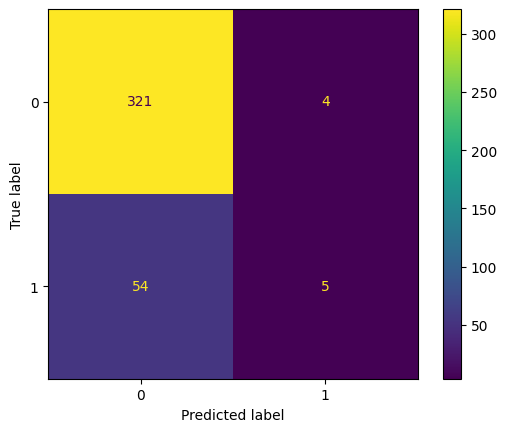

In [13]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = best_gbm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_gbm.classes_)
disp.plot()

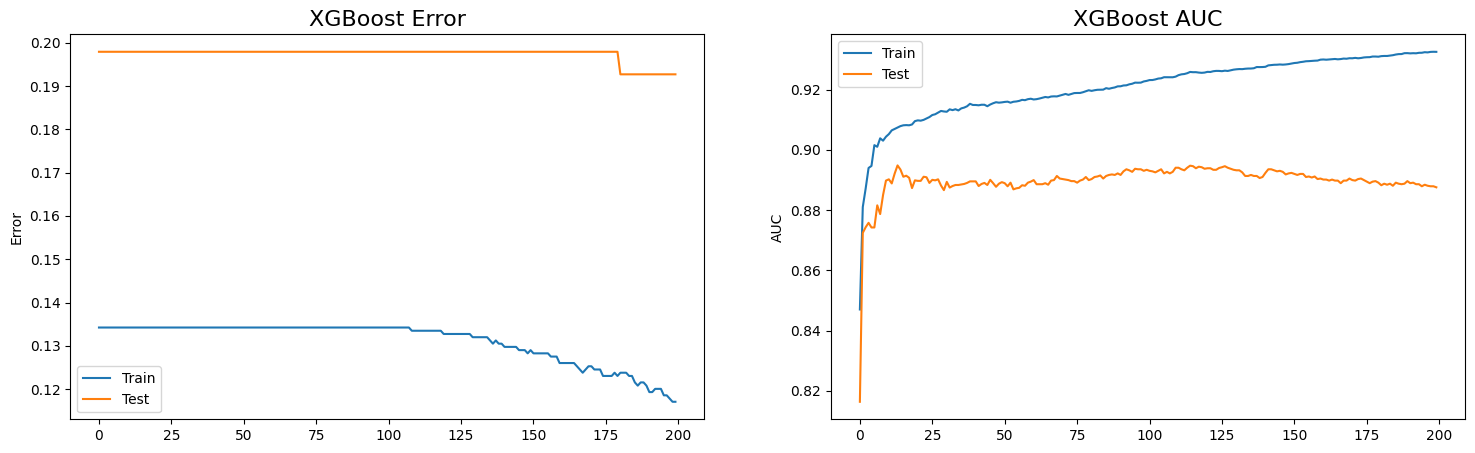

In [14]:
# retrieve performance metrics
results = best_gbm.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

# plot log loss and classification error 
fig, axs = plt.subplots(ncols=2, figsize=(18, 5))

# plot log loss
axs[0].plot(x_axis, results['validation_0']['error'], label='Train')
axs[0].plot(x_axis, results['validation_1']['error'], label='Test')
axs[0].legend()
axs[0].set_ylabel('Error')
axs[0].set_title('XGBoost Error', fontsize=16)

# plot classification error
axs[1].plot(x_axis, results['validation_0']['auc'], label='Train')
axs[1].plot(x_axis, results['validation_1']['auc'], label='Test')
axs[1].legend()
axs[1].set_ylabel('AUC')
axs[1].set_title('XGBoost AUC', fontsize=16)

plt.show()


### Evaluate the fitted model

In [15]:
# Print the classification report
from sklearn.metrics import classification_report, accuracy_score
y_pred_train = best_gbm.predict(X_train)
y_pred_val = best_gbm.predict(X_val)
y_pred_test = best_gbm.predict(X_test)

# print accuracy for train, val and test
print("Train Accuracy: ", accuracy_score(y_train, y_pred_train))
print("Validation Accuracy: ", accuracy_score(y_val, y_pred_val))
print("Test Accuracy: ", accuracy_score(y_test, y_pred_test))


Train Accuracy:  0.8829231916480239
Validation Accuracy:  0.8072916666666666
Test Accuracy:  0.8489583333333334


In [16]:
# print classification report for training
print('Train Classification Report')
print(classification_report(y_train, y_pred_train))

Train Classification Report
              precision    recall  f1-score   support

         0.0       0.89      0.99      0.94      1161
         1.0       0.78      0.18      0.29       180

    accuracy                           0.88      1341
   macro avg       0.83      0.59      0.61      1341
weighted avg       0.87      0.88      0.85      1341



In [17]:
# Print the classification report for test
print("Test classification report:")
print(classification_report(y_test, y_pred_test))

Test classification report:
              precision    recall  f1-score   support

         0.0       0.86      0.99      0.92       325
         1.0       0.56      0.08      0.15        59

    accuracy                           0.85       384
   macro avg       0.71      0.54      0.53       384
weighted avg       0.81      0.85      0.80       384



### Plot the AUC for training and Test

### Plot feature importance for classification

In [18]:
#plot tree
from xgboost import plot_tree
import matplotlib.pyplot as plt


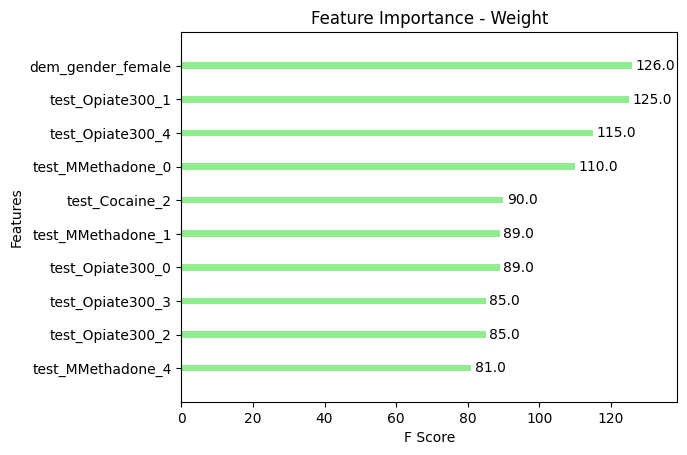

In [19]:
# plot feature importance
xgb.plot_importance(grid_auc.best_estimator_, importance_type='weight', max_num_features=10, title='Feature Importance - Weight', xlabel='F Score', ylabel='Features', color='lightgreen', grid=False)
plt.show()

In [20]:
from sklearn.model_selection import RandomizedSearchCV

# Create the parameter grid: gbm_param_grid 
gbm_param_grid = {
    'n_estimators': [25],
    'max_depth': range(2, 12)
}

# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor(n_estimators=10)

# Perform random search: grid_mse
randomized_mse = RandomizedSearchCV(param_distributions=gbm_param_grid,
estimator=gbm, scoring='neg_mean_squared_error', n_iter=5, cv=4, verbose=1)


# Fit randomized_mse to the data
randomized_mse.fit(X, y)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))

Fitting 4 folds for each of 5 candidates, totalling 20 fits
Best parameters found:  {'n_estimators': 25, 'max_depth': 4}
Lowest RMSE found:  0.17790831468075383
